## VGG19 Custom

2021/ 05/ 21<br>
Deadline = 2021/05/23<br>
인공지능 부산반 정희석

**necessary condition**:<br>
⁠⁠Pytorch 라이브러리를 이용 (오른쪽 표 참고)<br>
**⁠Original VGG-19에서 FC 변형되었으니 주의바람!** <br> ⁠Dataset 구성:⁠Pytorch 에서 CIFAR10 dataset을 download 및 dataset 구성⁠ 전처리 및 augmentation:<br> **아래를 포함하도록 구성**⁠
- Transforms.RandomCrop(32, padding=4)
- ⁠Transforms.RandomHorizontalFlip()⁠
- Transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))⁠
- 각 Convolution 은 3x3 size, padding =1 로 둔다.⁠
- 각 Convolution 마다 batch normalization 및 Relu 추가
- ⁠Loss function: Cross Entropy loss⁠Optimization: Adam optimization(learning_rate = 0.001)⁠
- 마지막 FC layer는 FC-10이 되게 바꾼다.
- ⁠FC마다 dropout (p=0.2)를 추가한다. (마지막 FC 제외)⁠
- Batch size =100로 둔다.
- ⁠Epoch = 10  
- training 후에 ⁠test accuracy를 계산하여 화면에 print 한다.⁠
- Training 은 반드시 **gpu**에서 수행되도록 설정함.⁠
- 기타 hyper parameter는 자유롭게 정함.


 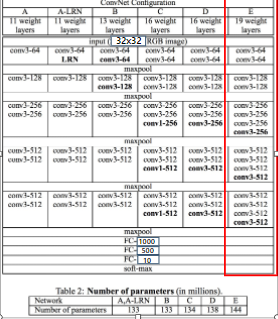

**필요한 모듈 import**

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torch
import torchvision
import torchvision.transforms as transforms

**데이터 다운로드 및 가공**

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), # Normalize보다 선행되어야 함.
     transforms.RandomCrop(32, padding=4), # Condition 3-1.
     transforms.RandomHorizontalFlip(),    # Condition 3-2.
     transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))]) # Condition 3-3.

batch_size = 100 # Condition 10.
# Condition 2.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # 다운로드 하면서 가공까지 완료.

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform) # 다운로드 하면서 가공까지 완료.


Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # 학습용 데이터는 무작위성을 위해 shuffle를 진행.

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 테스트용 데이터는 shuffle를 할 필요가 없음.

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
print(len(train_loader)) #Train dataset 개수 -> batch_size = 100 -> 500 * 100 => 5만개

500


In [5]:
print(len(test_loader))

100


## 3. Model 
### 1) Basic Blocks

- 모델에 반복되는 부분이 많기 때문에 이를 함수로 만들어 단순화 합니다.
- 맨 위에 이미지를 보면 컨볼루션 연산이 2번 연속하는 경우와 3번 연속하는 경우가 있는데 이를 각각 만들어줍니다.
- 아래의 코드는 최적의 방법이라기 보다는 그림의 구조를 모방한 코드입니다. 

In [6]:
# 컨볼루션 연산이 2번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_2_block(in_dim,out_dim): #
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.MaxPool2d(2,2)
    )
    return model

  
# 컨볼루션 연산이 3번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.MaxPool2d(2,2)
    )
    return model

# 컨볼루션 연산이 4번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_4_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
        nn.MaxPool2d(2,2)
    )
    return model

### 2) VGG Model

 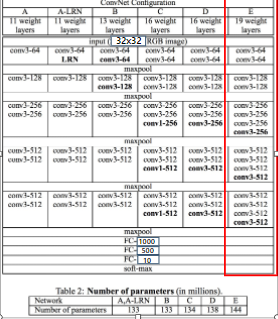

In [7]:
# 위에서 정의한 블록들을 이용해 VGG 네트워크를 만들어보겠습니다.
# 필터의 개수가 2의 n승의 값을 가지기 때문에 base_dim이란 변수를 추가해서 단순화 했습니다.
# 현재 dog, cat 두 가지 클래스를 구분하려고 하기 때문에 num_classes=2로 설정했습니다.

class VGG_19(nn.Module): # VGG_19 => MNIST는 28x28 데이터 => 모든 depth 내려가면 512x0x0이 되므로 가장 마지막 블럭은 스킵
    def __init__(self, base_dim, num_classes=10):
        super(VGG_19, self).__init__()
        self.feature = nn.Sequential(
            # input -> (3 channel(RGB), 32 x 32 pixel) => (3,32,32)
            conv_2_block(3,base_dim),
            # maxpooling filter = 2x2, stride = 2 => dimention / 2
            # base_dim = 64 => (64,16,16)
            conv_2_block(base_dim,2*base_dim),
            # base_dim = 64 => (128,8,8)
            conv_4_block(2*base_dim,4*base_dim),
            # base_dim = 64 => (256,4,4)
            conv_4_block(4*base_dim,8*base_dim),
            # base_dim = 64 => (512,2,2)
            conv_4_block(8*base_dim,8*base_dim),
            # base_dim = 64 => (512,1,1)            
        )
        self.fc_layer = nn.Sequential(
            # base_dim = 64 => (512,1,1) -> x.view(x.size(0), -1) (== flatten()) => 512x1x1
            nn.Linear(8*base_dim * 1 * 1, 1000),
            nn.ReLU(True),                                                      
            # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            nn.Dropout(0.2),
            nn.Linear(1000, 500),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(500, num_classes),
            # Softmax는 Linear에 ReLU activation을 통과하지 않는다면 기본적으로 적용된다. - 출처: torch/vision/models/vgg.py
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x)
        return x
    

In [8]:
!pip install torchinfo
from torchinfo import summary
from torchvision import models

vgg_19 = VGG_19(base_dim = 64)
#모델 모양 출력
summary(vgg_19, (10, 3, 32, 32)) #신경망 모델 확인하기

Layer (type:depth-idx)                   Output Shape              Param #
VGG_19                                   --                        --
├─Sequential: 1-1                        [10, 512, 1, 1]           --
│    └─Sequential: 2-1                   [10, 64, 16, 16]          --
│    │    └─Conv2d: 3-1                  [10, 64, 32, 32]          1,792
│    │    └─BatchNorm2d: 3-2             [10, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [10, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [10, 64, 32, 32]          36,928
│    │    └─BatchNorm2d: 3-5             [10, 64, 32, 32]          128
│    │    └─ReLU: 3-6                    [10, 64, 32, 32]          --
│    │    └─MaxPool2d: 3-7               [10, 64, 16, 16]          --
│    └─Sequential: 2-2                   [10, 128, 8, 8]           --
│    │    └─Conv2d: 3-8                  [10, 128, 16, 16]         73,856
│    │    └─BatchNorm2d: 3-9             [10, 128, 16, 16]         256
│

GPU 이식

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Condition 12.

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [10]:
vgg_19.to(device)

VGG_19(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, s

학습

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() #손실함수 # Condition 6.
optimizer = optim.Adam(vgg_19.parameters(),lr = 0.001) #최적화함수 Condition 7.

In [12]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.
    print('epoch:',epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = vgg_19(inputs) # 데이터를 모델에 통과하여 결과 예측(순전파)
        loss = criterion(outputs, labels) # 해당 결과를 기반으로 오류 검사
        loss.backward()  # 손실을 바탕으로 역전파 진행 
        optimizer.step() # 최적화 진행

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        #
        # if (i+1) % 100 == 0:
        #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

print('Finished Training')

epoch: 0
[1,   100] loss: 2.053
[1,   200] loss: 1.917
[1,   300] loss: 1.880
[1,   400] loss: 1.877
[1,   500] loss: 1.801
epoch: 1
[2,   100] loss: 1.761
[2,   200] loss: 1.695
[2,   300] loss: 1.648
[2,   400] loss: 1.572
[2,   500] loss: 1.529
epoch: 2
[3,   100] loss: 1.474
[3,   200] loss: 1.438
[3,   300] loss: 1.391
[3,   400] loss: 1.380
[3,   500] loss: 1.331
epoch: 3
[4,   100] loss: 1.269
[4,   200] loss: 1.239
[4,   300] loss: 1.177
[4,   400] loss: 1.127
[4,   500] loss: 1.117
epoch: 4
[5,   100] loss: 1.053
[5,   200] loss: 1.032
[5,   300] loss: 0.982
[5,   400] loss: 0.968
[5,   500] loss: 0.939
epoch: 5
[6,   100] loss: 0.928
[6,   200] loss: 0.882
[6,   300] loss: 0.864
[6,   400] loss: 0.857
[6,   500] loss: 0.862
epoch: 6
[7,   100] loss: 0.789
[7,   200] loss: 0.792
[7,   300] loss: 0.776
[7,   400] loss: 0.772
[7,   500] loss: 0.769
epoch: 7
[8,   100] loss: 0.727
[8,   200] loss: 0.703
[8,   300] loss: 0.728
[8,   400] loss: 0.709
[8,   500] loss: 0.689
epoch: 8

테스트 정확도

In [13]:
dataiter = iter(test_loader) # 테스트 데이터 불러오기
images, labels = dataiter.next()
correct = 0
total = 0
with torch.no_grad(): # 이 부분은 CIFAR 튜토리얼에서 사용한 방식 그대로.
    for data in test_loader: # batci_size 만큼 긁어오는 느낌
        images, labels = data[0].to(device), data[1].to(device) #to device : cpu용 tensor -> gpu(cuda)용 tensor로 변환
        outputs = vgg_19(images) # 예측 진행.
        _, predicted = torch.max(outputs.data, 1) #여기 max가 softmax의 역할을 한다...?
        total += labels.size(0) # 몇 개를 읽어 들였다. => 라벨의 개수. => batch_size
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %
Test Accuracy of the model on the 10000 test images: 81.05 %


In [14]:
# Test the model again using the saved weight file
vgg_19.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad(): # gradient 계산을 안한다. => 예측이기 때문에 미분값을 계산할 필요가 없기 때문에 메모리와 속도를 아낄 수 있다.
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg_19(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 81.73 %


클래스별 예측 정확도

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) #to device : cpu용 tensor -> gpu(cuda)용 tensor로 변환
        outputs = vgg_19(images) # 예측 진행.
        _, predicted = torch.max(outputs, 1) # classify
        c = (predicted == labels).squeeze() # https://dowant.tistory.com/entry/numpy-npsqueeze
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 88 %
Accuracy of   car : 96 %
Accuracy of  bird : 63 %
Accuracy of   cat : 69 %
Accuracy of  deer : 79 %
Accuracy of   dog : 71 %
Accuracy of  frog : 86 %
Accuracy of horse : 84 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %
